In [9]:
%matplotlib notebook
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr

sys.path.append('..')
import project

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T10/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T20/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T30/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T40/lung_regions.nii.gz


<IPython.core.display.Javascript object>


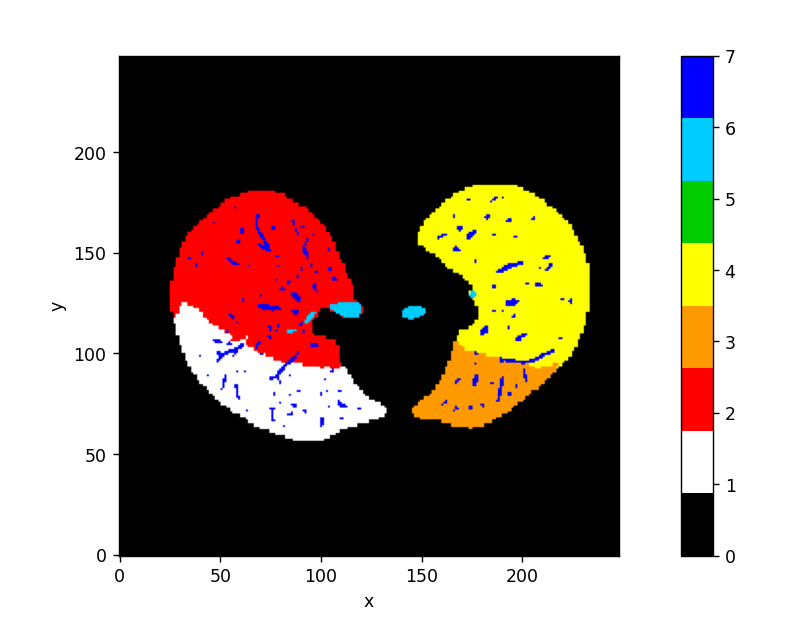

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

In [11]:
case = project.imaging.Emory4DCT('../data/Emory-4DCT')[0]
case.load_niftis()
case.load_masks(roi='lung_regions')
case.mask.name = 'regions'
project.visual.XArrayViewer(case.mask)

coords


<IPython.core.display.Javascript object>


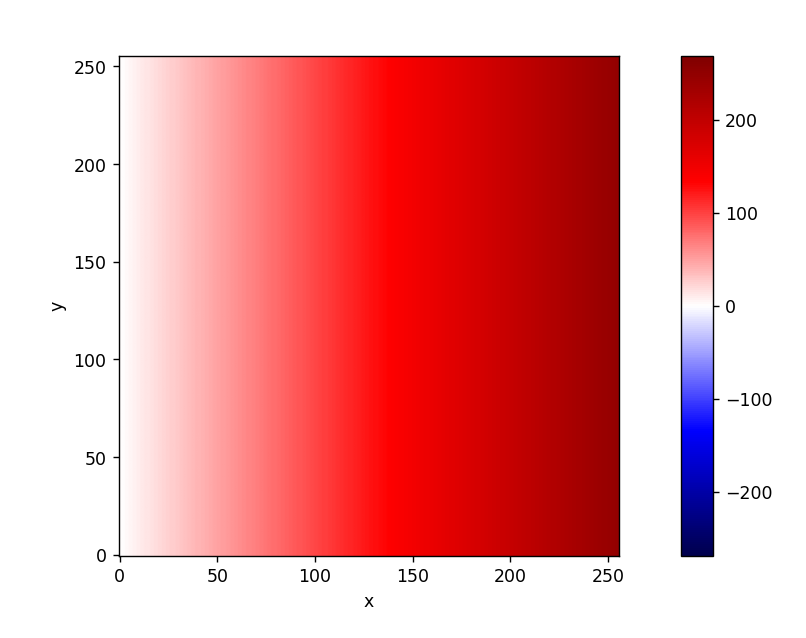

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [12]:
shape = case.shape
resolution = case.resolution

def spatial_coordinates(shape, resolution):
    x = np.arange(shape[0]) * resolution[0]
    y = np.arange(shape[1]) * resolution[1]
    z = np.arange(shape[2]) * resolution[2]
    return np.stack(np.meshgrid(x, y, z, indexing='ij'), axis=-1)

coords = spatial_coordinates(shape, resolution)

project.visual.XArrayViewer(
    project.utils.as_xarray(coords, dims=['x', 'y', 'z', 'component'], name='coords')
)

freqs


<IPython.core.display.Javascript object>


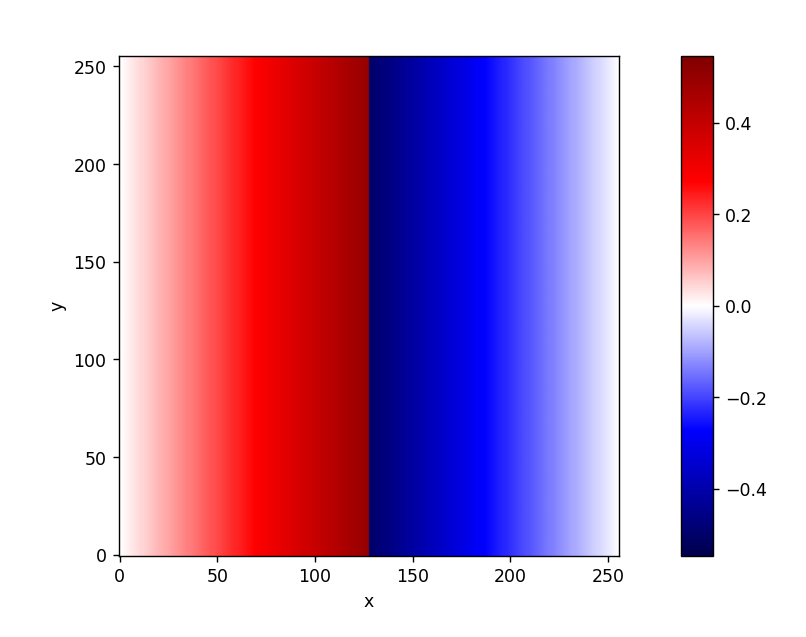

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [13]:
def frequency_coordinates(shape):
    x = np.fft.fftfreq(shape[0])
    y = np.fft.fftfreq(shape[1])
    z = np.fft.fftfreq(shape[2])
    return np.stack(np.meshgrid(x, y, z, indexing='ij'), axis=-1)
    
freqs = frequency_coordinates(shape)

project.visual.XArrayViewer(
    project.utils.as_xarray(freqs, dims=['x', 'y', 'z', 'component'], name='freqs')
)

filter


<IPython.core.display.Javascript object>


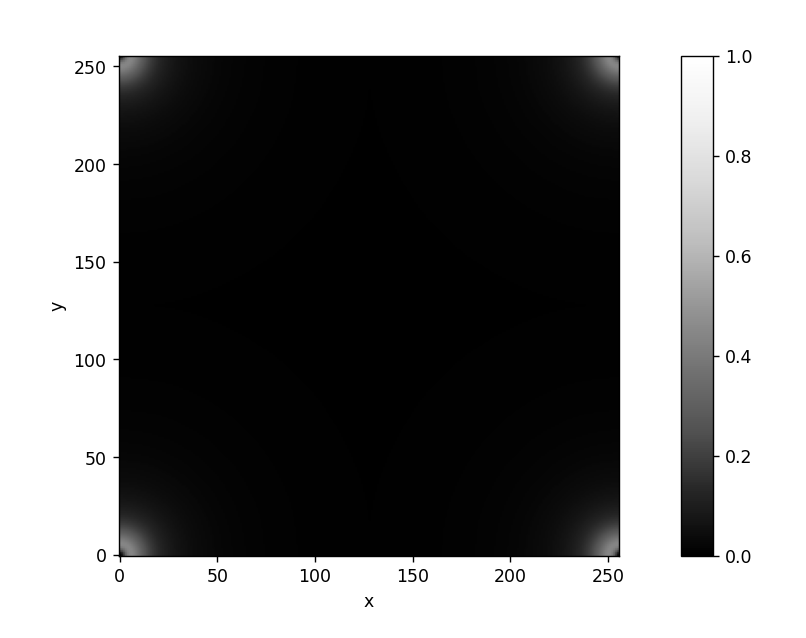

interactive(children=(SelectionSlider(description='f', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4)), value…

In [14]:
def butterworth_filter(freqs, cutoff, power):
    radius = np.linalg.norm(freqs, axis=-1)
    return 1 / (1 + (radius/cutoff)**power)


def bandpass_filter(freqs, cutoff1, cutoff2, power):
    filter1 = butterworth_filter(freqs, cutoff1, power)
    filter2 = butterworth_filter(freqs, cutoff2, power)
    return (1 - filter1) * filter2


filters = np.stack([
    bandpass_filter(freqs, c/2, c, power=2) for c in np.logspace(-3, 0, 5)
])

project.visual.XArrayViewer(
    project.utils.as_xarray(
        filters,
        dims=['f', 'x', 'y', 'z'],
        name='filter'
    ),
    cmap='Greys_r', vmin=0, vmax=1,
)

texture


<IPython.core.display.Javascript object>


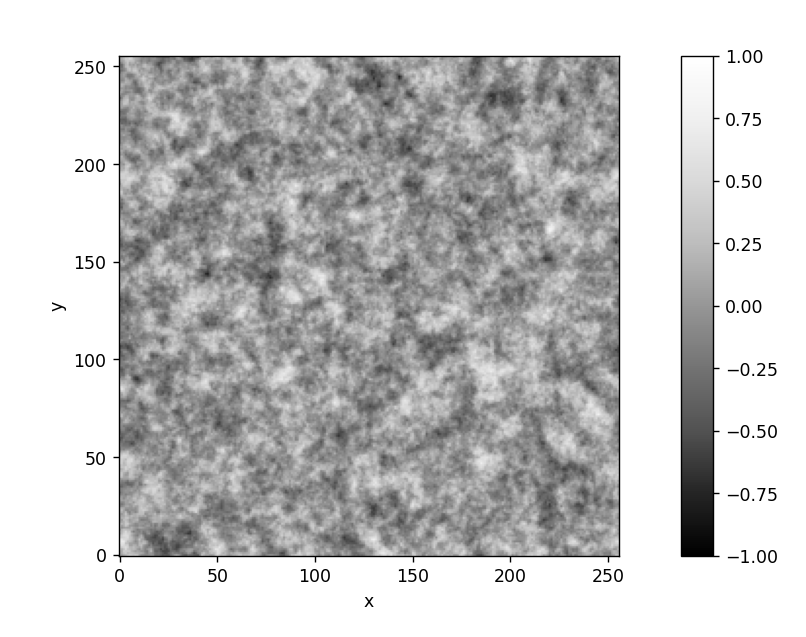

interactive(children=(SelectionSlider(description='f', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4)), value…

In [18]:
def random_texture(filter_):
    complex_noise = (
        np.random.normal(0, 1, filter_.shape) + 
        np.random.normal(0, 1, filter_.shape) * 1j
    )
    texture = np.fft.ifftn(complex_noise * filter_).real
    texture -= texture.min()
    texture /= texture.max()
    return texture * 2 - 1

texture = np.stack([
    random_texture(f) for f in filters
])

project.visual.XArrayViewer(
    project.utils.as_xarray(
        texture,
        dims=['f', 'x', 'y', 'z'],
        name='texture'
    ),
    cmap='Greys_r', vmin=-1, vmax=1,
)

mask


<IPython.core.display.Javascript object>


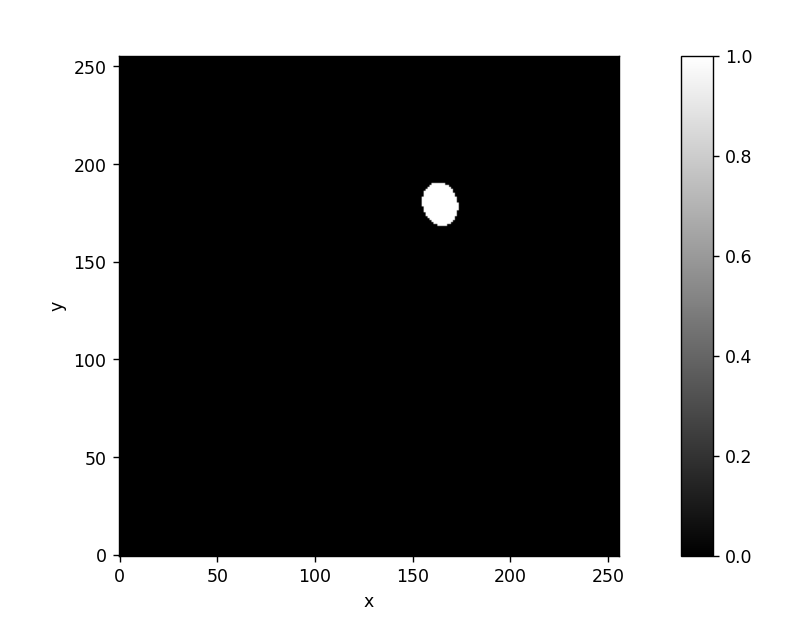

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [19]:
import scipy.stats

def draw_target(coords, center, radius, rotation):
    displacement = ((coords - center) @ rotation) / radius
    distance = np.linalg.norm(displacement, ord=2, axis=-1)
    return (distance <= 1).astype(int)

def draw_random_target(coords, radius_min, radius_max, pad=0.2, iso=False):
    coords_min = coords.min(axis=(0,1,2))
    coords_max = coords.max(axis=(0,1,2))
    coords_range = coords_max - coords_min
    center_min = coords_min + coords_range * pad
    center_max = coords_max - coords_range * pad
    center = np.random.uniform(center_min, center_max)
    radius = np.random.uniform(radius_min, radius_max, (1 if iso else 3))
    rotation = scipy.stats.ortho_group.rvs(3)
    return draw_target(coords, center, radius, rotation)

target = draw_random_target(coords, radius_min=5, radius_max=25)

project.visual.XArrayViewer(
    project.utils.as_xarray(
        target,
        dims=['x', 'y', 'z'],
        name='mask',
    )
)

5 41
regions


<IPython.core.display.Javascript object>


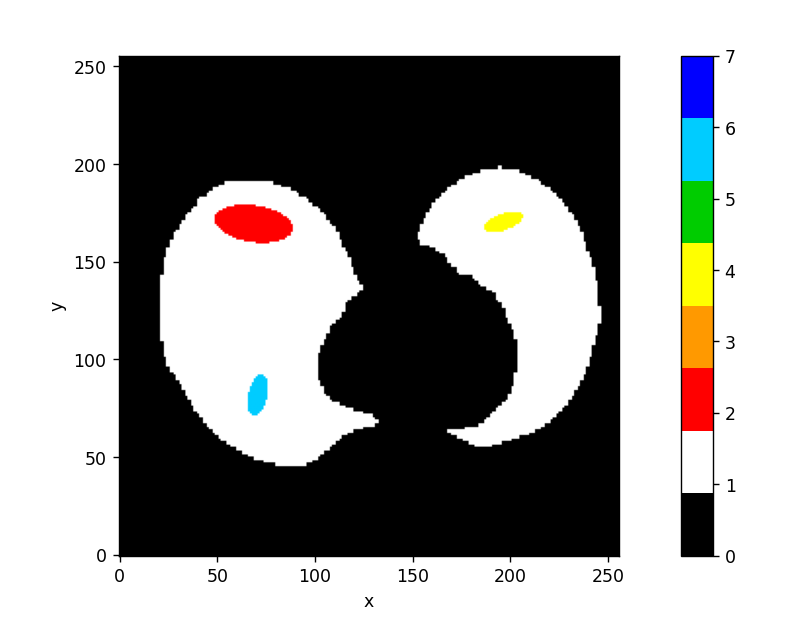

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [20]:
def add_non_overlapping_targets(regions, resolution, max_targets, radius_min, radius_max):
    coords = spatial_coordinates(regions.shape, resolution)
    regions = np.array(regions)
    target_count = 0
    attempt_count = 0
    while (target_count < max_targets) and (attempt_count < max_targets * 10):
        target = draw_random_target(coords, radius_min, radius_max)
        collisions = np.logical_and(target, (regions != 1))
        if not np.any(collisions):
            target_count += 1
            regions += target * target_count
        attempt_count += 1
    print(target_count, attempt_count)
    return regions

regions = (case.mask.sel(phase=0, roi='lung_regions').values > 0).astype(int)
regions = add_non_overlapping_targets(regions, resolution, max_targets=5, radius_min=5, radius_max=30)

project.visual.XArrayViewer(
    project.utils.as_xarray(
        regions,
        dims=['x', 'y', 'z'],
        name='regions',
    )
)

[0.87127912 0.82017069 0.54915289 0.09544675 0.33329364 0.73532162
 0.62030439]
[   0.         4368.59103185 1254.0238139   155.20064067  464.07404521
 2955.58350898 1740.23850305]
elast


<IPython.core.display.Javascript object>


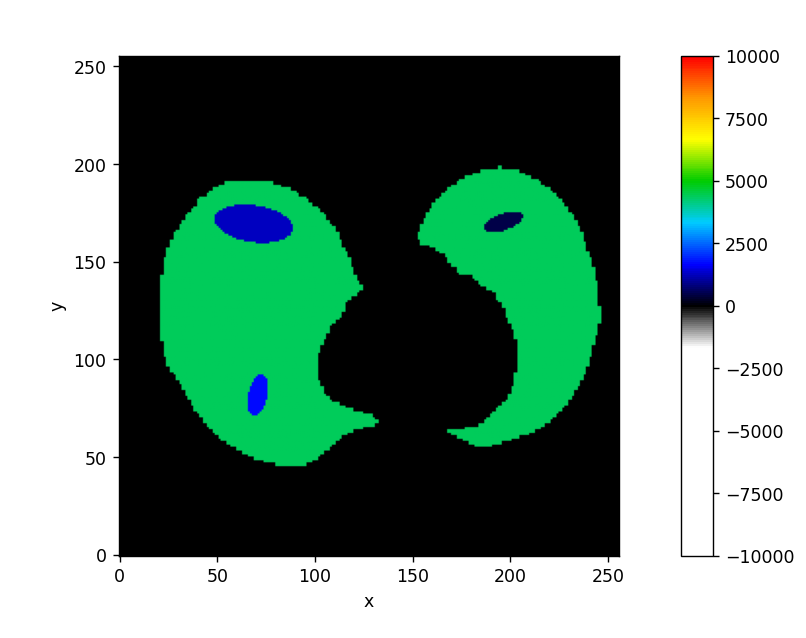

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [21]:
n_regions = int(regions.max()) + 1
region_id = np.arange(n_regions)
region_indicator = (regions[None,...] == region_id[:,None,None,None])

# sample latent variables

latent = np.random.rand(n_regions)
print(latent)

# assign stiffness to regions

min_log_kpa = -1
max_log_kpa =  1
log_kpa = latent * (max_log_kpa - min_log_kpa) + min_log_kpa

mu = 10**log_kpa * 1000
mu[0] = 0
print(mu)

mu = (region_indicator * mu[:,None,None,None]).sum(axis=0)

project.visual.XArrayViewer(
    project.utils.as_xarray(mu, dims=['x', 'y', 'z'], name='elast'), vmin=-1e4, vmax=1e4
)

In [22]:
# map latent variables to texture bias and filter parameters

anat_range = 2000
bias_range = 1000
bias_midpt = 0
bias_max = bias_midpt + bias_range/2
bias_min = bias_midpt - bias_range/2

bias = latent * bias_range + bias_min
bias[0] = bias_midpt - anat_range/2
bias

array([-1000.        ,   320.17069494,    49.15289191,  -404.55324514,
        -166.70636009,   235.32161735,   120.30438663])

In [23]:
log_cutoff_max =  0
log_cutoff_min = -3
log_cutoff_range = log_cutoff_max - log_cutoff_min

log_cutoff = latent * log_cutoff_range + log_cutoff_min
cutoff = 10**log_cutoff
cutoff

array([0.41099577, 0.28874341, 0.04440774, 0.00193348, 0.00999726,
       0.16068112, 0.07259608])

texture


<IPython.core.display.Javascript object>


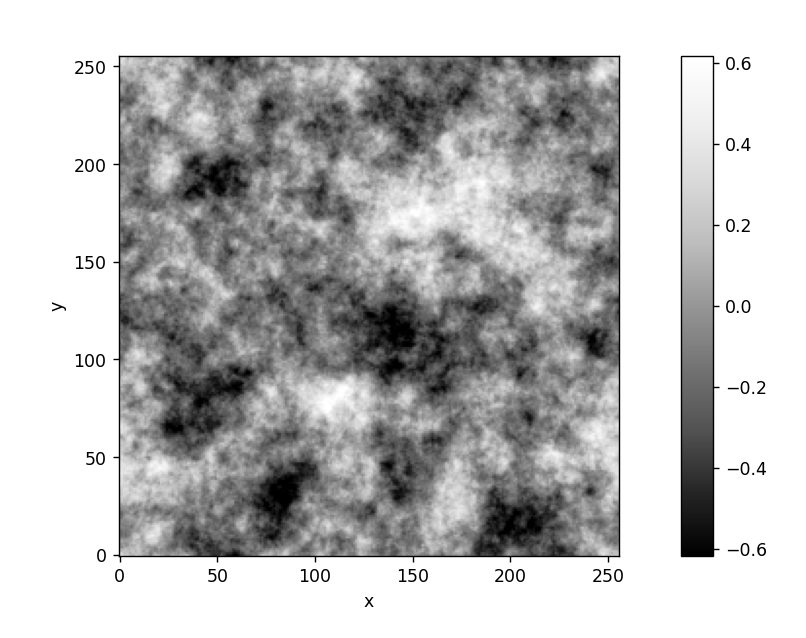

interactive(children=(SelectionSlider(description='f', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [24]:
texture = np.zeros_like(region_indicator, dtype=float)
for i in range(n_regions):
    filter_ = bandpass_filter(freqs, cutoff[i]/2, cutoff[i], power=2)
    texture[i] = random_texture(filter_)

texture[0] = 0

project.visual.XArrayViewer(
    project.utils.as_xarray(texture, dims=['f', 'x', 'y', 'z'], name='texture'), cmap='Greys_r'
)

-1000.0 806.6502756701022
anat


<IPython.core.display.Javascript object>


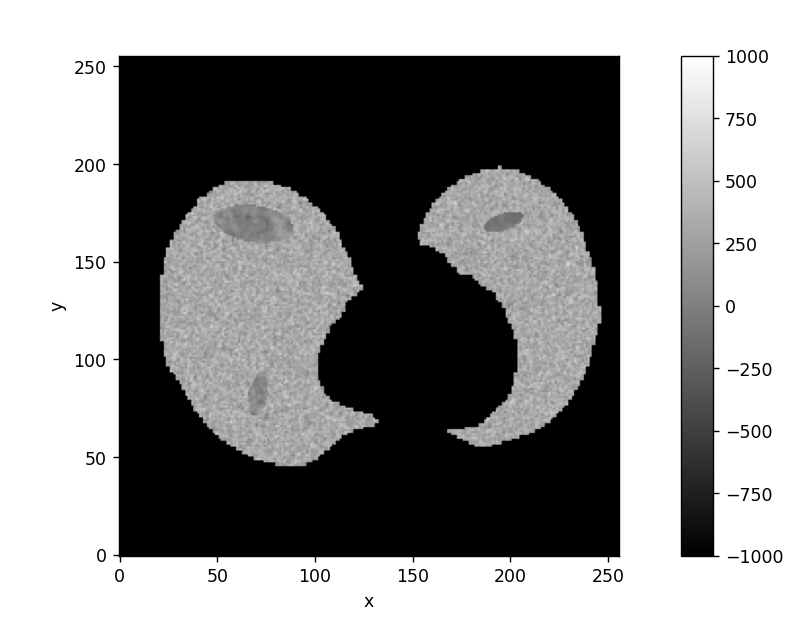

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [25]:
texture_range = anat_range - bias_range
anat = texture * texture_range/2 + bias[:,None,None,None]
anat = (region_indicator * anat).sum(axis=0)
print(anat.min(), anat.max())

project.visual.XArrayViewer(
    project.utils.as_xarray(anat, dims=['x', 'y', 'z'], name='anat')
)

displacement


<IPython.core.display.Javascript object>


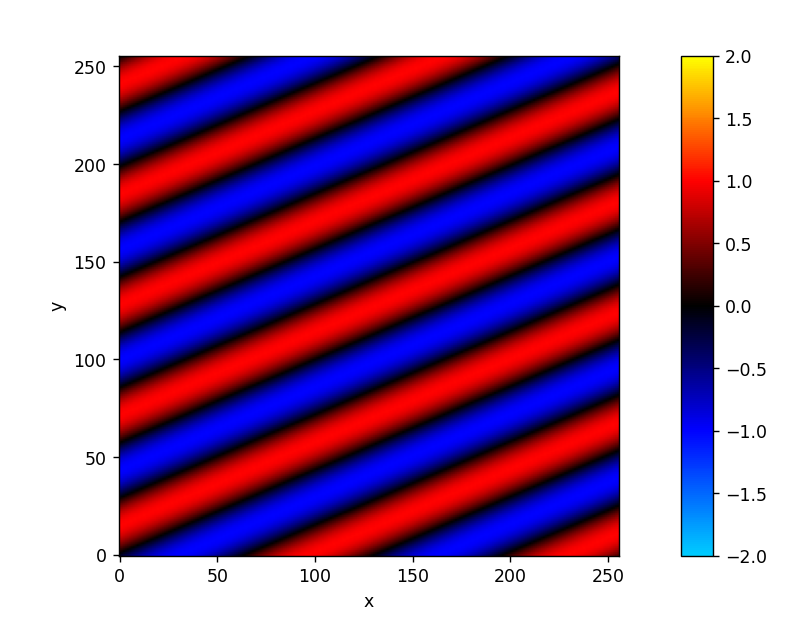

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [26]:
phase_sigma = 2
phase = np.random.normal(0, phase_sigma, (3, 3))
extent = np.max(shape) * np.array(resolution)

disp_bc = np.sin(2 * np.pi * (coords/extent) @ phase)

project.visual.XArrayViewer(
    project.utils.as_xarray(disp_bc, dims=['x', 'y', 'z', 'c'], name='displacement'), vmin=-2, vmax=2
)

In [29]:
import pygalmesh

mesh = pygalmesh.generate_from_array(
    regions.astype(np.uint16),
    voxel_size=resolution,
    max_cell_circumradius=10.0,
    min_facet_angle=15,
    max_facet_distance=1.0,
    odt=True,
    lloyd=True
)
mesh = project.meshing.remove_unused_points(mesh)

mesh_file = 'lung.xdmf'
project.meshing.save_mesh_meshio(mesh_file, mesh, cell_blocks=[1])
mesh = project.meshing.load_mesh_fenics(mesh_file)
mesh

Loading lung.xdmf... 5301


In [30]:
print('\n'*4)

In [34]:
import torch

# convert to FEM basis coefficients
mesh_radius = 10
device = 'cpu'
dtype = torch.float32
pde_ = project.pde.LinearElasticPDE(mesh)
print('Interpolating FEM coefficients...')
u_dofs = project.interpolation.image_to_dofs(
    torch.as_tensor(disp_bc, dtype=dtype, device=device).permute(3, 0, 1, 2),
    resolution, pde_.V,
    radius=int(mesh_radius),
    sigma=mesh_radius/2
)
mu_dofs = project.interpolation.image_to_dofs(
    torch.as_tensor(mu, dtype=dtype, device=device),
    resolution, pde_.S,
    radius=int(mesh_radius),
    sigma=mesh_radius/2
)
anat_dofs = project.interpolation.image_to_dofs(
    torch.as_tensor(anat, dtype=dtype, device=device),
    resolution, pde_.S,
    radius=int(mesh_radius),
    sigma=mesh_radius/2
)
rho_dofs = (1 + anat_dofs/1000) * 1000

Interpolating FEM coefficients...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [35]:
# solve FEM for simulated displacement dofs
print('Solving FEM model...')
u_sim_dofs = pde_.forward(
    u_dofs.unsqueeze(0),
    mu_dofs.unsqueeze(0),
    rho_dofs.unsqueeze(0),
)[0]

Solving FEM model...


Converting displacement to image...
displacement


<IPython.core.display.Javascript object>


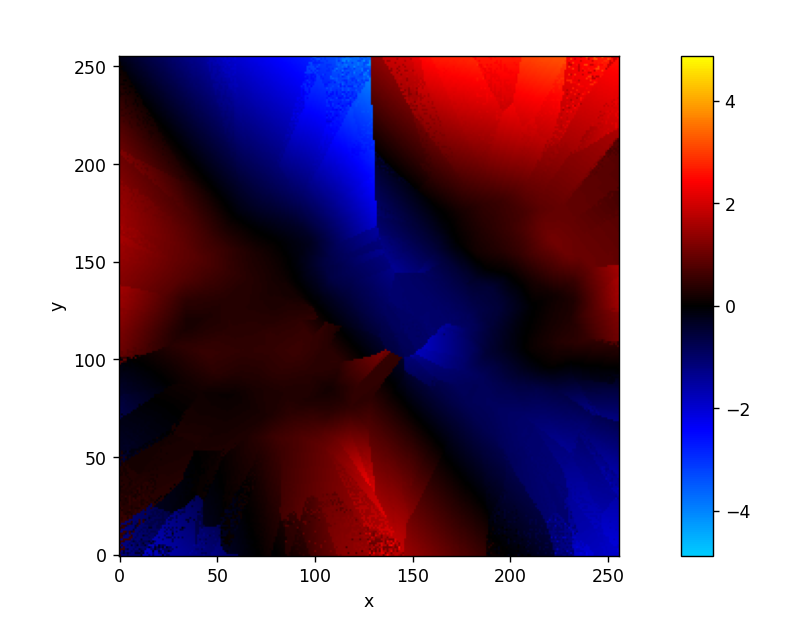

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [37]:
# convert to displacement image
print('Converting displacement to image...')
disp_sim = project.interpolation.dofs_to_image(
    u_sim_dofs, pde_.V, disp_bc.shape[:3], resolution
).permute(1,2,3,0)

project.visual.XArrayViewer(
    project.utils.as_xarray(
        disp_sim, dims=['x', 'y', 'z', 'c'], name='displacement'
    )
)

Setting random seed to None
Defining spatial domain...
4 50
Sampling latent variables...
[0.7235963  0.65489782 0.55519743 0.00613355 0.73466936 0.9237383 ]
Generating stiffness map..
[   0.         2040.7774631  1289.42138623  102.86487442 2946.71895738
 7038.44315705]
Generating anatomical image...
Generating displacement BC...
Generating mesh...
Loading phantom.xdmf... 5285
Interpolating FEM coefficients...
Solving FEM model...
Converting displacement to image...
elast


<IPython.core.display.Javascript object>


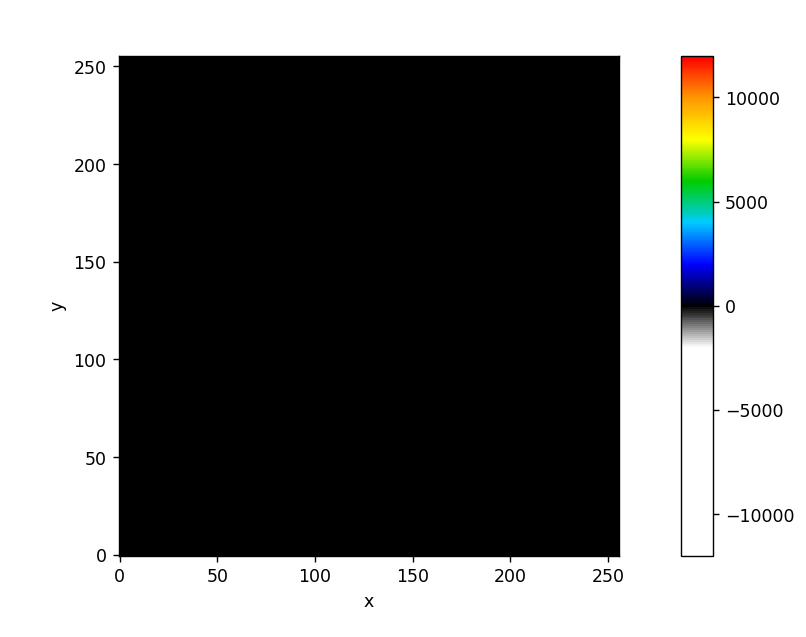

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

anat


<IPython.core.display.Javascript object>


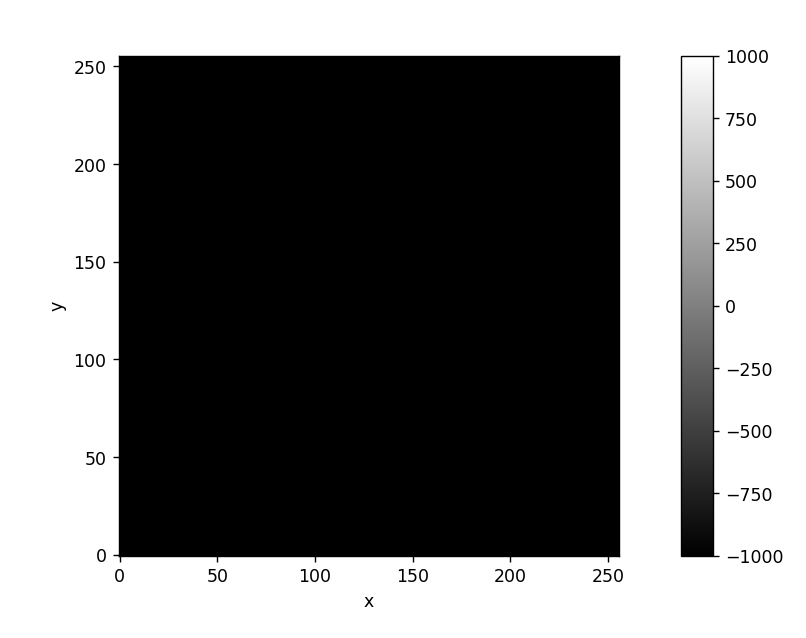

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

disp


<IPython.core.display.Javascript object>


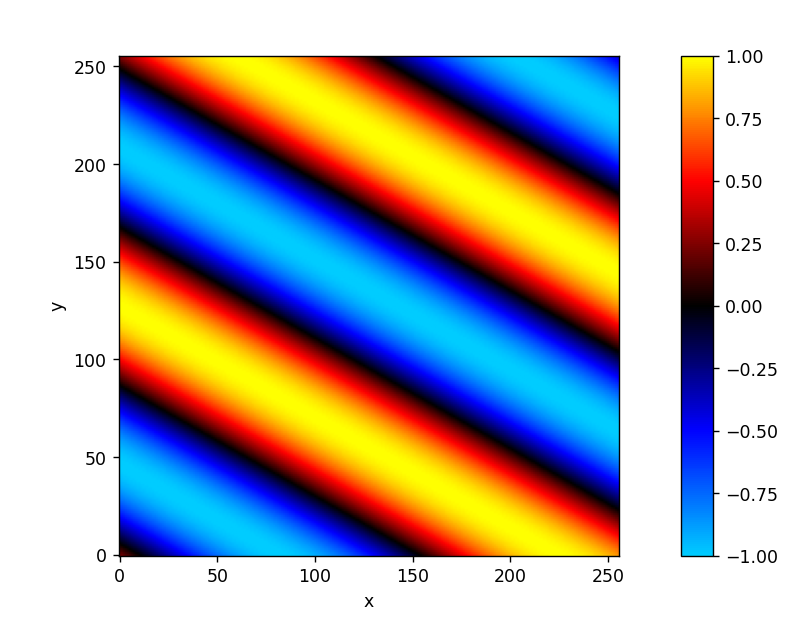

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

disp


<IPython.core.display.Javascript object>


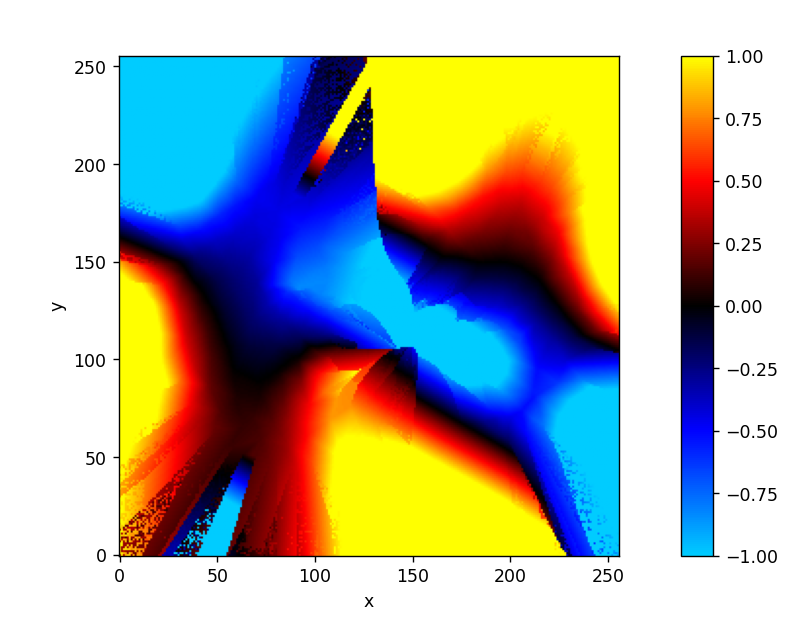

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [43]:
%autoreload
import torch
import nibabel as nib

from project import meshing, interpolation, pde

def generate_phantom(
    mask,
    resolution,
    max_targets=5,
    radius_min=5,
    radius_max=25,
    log_kpa_min=-1,
    log_kpa_max=1,
    bias_midpoint=0,
    bias_range=500,
    anat_range=2000,
    log_cutoff_min=-3,
    log_cutoff_max=0,
    phase_sigma=1.0,
    mesh_radius=10,
    mesh_file='phantom.xdmf',
    random_seed=None
):
    print(f'Setting random seed to {random_seed}')
    np.random.seed(random_seed)
    
    # define coordinates over spatial domain
    print('Defining spatial domain...')
    coords = spatial_coordinates(mask.shape, resolution)

    # define spatial regions for target and background
    regions = add_non_overlapping_targets(mask, resolution, max_targets, radius_min, radius_max)
    n_regions = 1 + int(regions.max())
    region_id = np.arange(n_regions)
    region_indicator = (regions[None,...] == region_id[:,None,None,None])

    # sample latent variables for each region
    print('Sampling latent variables...')
    latent = np.random.rand(n_regions)
    print(latent)

    # map latent variables to stiffness values
    print('Generating stiffness map..')
    log_kpa_range = (log_kpa_max - log_kpa_min)
    log_kpa = latent * log_kpa_range + log_kpa_min
    mu = np.power(10, log_kpa) * 1000 # log kPa -> Pa
    mu[0] = 0 # background stiffness
    print(mu)

    # assign stiffness to each spatial region
    mu = (region_indicator * mu[:,None,None,None]).sum(axis=0)
    mu[0] = 0 # background stiffness

    # map latent variables to anatomical texture parameters
    print('Generating anatomical image...')
    bias_min = bias_midpoint - bias_range/2
    bias = latent * bias_range + bias_min

    log_cutoff_range = (log_cutoff_max - log_cutoff_min)
    log_cutoff = latent * log_cutoff_range + log_cutoff_min
    cutoff = np.power(10, log_cutoff)

    freq_coords = frequency_coordinates(shape)
    texture = np.zeros_like(region_indicator, dtype=float)
    for i in range(n_regions):
        filter_ = bandpass_filter(freq_coords, cutoff[i]/2, cutoff[i], power=2)
        texture[i] = random_texture(filter_)

    texture_range = (anat_range - bias_range)
    anat = texture * texture_range/2 + bias[:,None,None,None]
    anat_min = bias_midpoint - anat_range/2
    anat[0] = anat_min

    # assign anatomical textures to each region
    anat = (region_indicator * anat).sum(axis=0)
    
    # generate random displacement boundary condition
    print('Generating displacement BC...')
    phase = np.random.normal(0, phase_sigma, (3, 3))
    extent = np.max(shape) * np.array(resolution)
    disp_bc = np.sin(2 * np.pi * (coords/extent) @ phase)

    # generate mesh using pygalmesh
    print('Generating mesh...')
    mask = regions.astype(np.uint16)
    mesh = pygalmesh.generate_from_array(
        mask, resolution,
        max_cell_circumradius=float(mesh_radius),
        min_facet_angle=15,
        max_facet_distance=1.0,
        odt=True, lloyd=True
    )
    mesh = meshing.remove_unused_points(mesh)
    
    # save mesh using meshio, then read with fenics
    project.meshing.save_mesh_meshio(mesh_file, mesh, cell_blocks=[1])
    mesh = project.meshing.load_mesh_fenics(mesh_file)
    
    # convert to FEM basis coefficients
    print('Interpolating FEM coefficients...')
    pde_ = pde.LinearElasticPDE(mesh)
    device = 'cpu'
    dtype = torch.float32
    u_dofs = interpolation.image_to_dofs(
        torch.as_tensor(disp_bc, dtype=dtype, device=device).permute(3, 0, 1, 2),
        resolution, pde_.V,
        radius=int(mesh_radius),
        sigma=mesh_radius/2
    )
    mu_dofs = interpolation.image_to_dofs(
        torch.as_tensor(mu, dtype=dtype, device=device),
        resolution, pde_.S,
        radius=int(mesh_radius),
        sigma=mesh_radius/2
    )
    anat_dofs = interpolation.image_to_dofs(
        torch.as_tensor(anat, dtype=dtype, device=device),
        resolution, pde_.S,
        radius=int(mesh_radius),
        sigma=mesh_radius/2
    )
    rho_dofs = (1 + anat_dofs/1000) * 1000
    
    # solve FEM for simulated displacement dofs
    print('Solving FEM model...')
    u_sim_dofs = pde_.forward(
        u_dofs.unsqueeze(0),
        mu_dofs.unsqueeze(0),
        rho_dofs.unsqueeze(0),
    )[0]
    
    # convert to displacement image
    print('Converting displacement to image...')
    disp_sim = interpolation.dofs_to_image(
        u_sim_dofs, pde_.V, disp_bc.shape[:3], resolution
    ).permute(1,2,3,0)
    
    return mu, anat, disp_bc, disp_sim, mask, mesh

mask = (case.mask.sel(phase=0, roi='lung_regions').values > 0).astype(int)
mu, anat, disp_bc, disp_sim, mask, mesh = generate_phantom(mask, resolution)

project.visual.XArrayViewer(project.utils.as_xarray(mu, dims=['x', 'y', 'z'], name='elast'))
project.visual.XArrayViewer(project.utils.as_xarray(anat, dims=['x', 'y', 'z'], name='anat'))
project.visual.XArrayViewer(project.utils.as_xarray(disp_bc, dims=['x', 'y', 'z', 'c'], name='disp'))
project.visual.XArrayViewer(project.utils.as_xarray(disp_sim, dims=['x', 'y', 'z', 'c'], name='disp'))

In [46]:
import pathlib

class PhantomSet(object):
    
    def __init__(self, data_root, num_phantoms):
        self.data_root = pathlib.Path(data_root)
        self.phantoms = []
        for i in range(num_phantoms):
            phantom = Phantom(data_root, phantom_id=i)
            self.phantoms.append(phantom)
            
    def generate(self, *args, **kwargs):
        self.data_root.mkdir(exist_ok=True)
        for i, phantom in enumerate(self.phantoms):
            phantom.generate(*args, **kwargs)
            
    def get_examples(self, mesh_radius):
        examples = []
        for i, phantom in enumerate(self.phantoms):
            examples.append({
                'name': phantom.phantom_name,
                'anat_file': phantom.anat_file(),
                'disp_file': phantom.disp_file(),
                'mask_file': phantom.mask_file(),
                'mesh_file': phantom.mesh_file(mesh_radius),
                'mesh_radius': mesh_radius
            })
        return examples


class Phantom(object):
    
    def __init__(self, data_root, phantom_id):
        self.data_root = pathlib.Path(data_root)
        self.phantom_id = int(phantom_id)
        
    @property
    def phantom_name(self):
        return f'phantom{self.phantom_id}'
        
    @property
    def phantom_dir(self):
        return self.data_root / self.phantom_name
        
    def anat_file(self):
        return self.phantom_dir / f'{self.phantom_name}_anat.nii.gz'

    def disp_file(self):
        return self.phantom_dir / f'{self.phantom_name}_disp.nii.gz'
    
    def elast_file(self):
        return self.phantom_dir / f'{self.phantom_name}_elast.nii.gz'
    
    def mask_file(self):
        return self.phantom_dir / f'{self.phantom_name}_mask.nii.gz'
    
    def mesh_file(self, mesh_radius):
        return self.phantom_dir / f'{self.phantom_name}_mesh{mesh_radius}.xdmf'
    
    def generate(self, mask_file, mesh_radius, **kwargs):
        self.phantom_dir.mkdir(exist_ok=True)
        
        nifti = nib.load(mask_file)
        mask = (nifti.get_fdata() > 0).astype(int)
        resolution = nifti.header.get_zooms()
        
        elast, anat, disp_bc, disp, mask, mesh = generate_phantom(
            mask=mask,
            resolution=resolution,
            mesh_radius=mesh_radius,
            mesh_file=self.mesh_file(mesh_radius),
            random_seed=self.phantom_id,
            **kwargs 
        )
        self.elast = project.utils.as_xarray(
            elast, dims=['x', 'y', 'z'], name='elasticity'
        )

        x = np.arange(shape[0]) * resolution[0]
        y = np.arange(shape[1]) * resolution[1]
        z = np.arange(shape[2]) * resolution[2]

        self.elast = xr.DataArray(
            data=elast,
            dims=['x', 'y', 'z'],
            coords=dict(x=x, y=y, z=z),
            name='elasticity'
        )
        self.anat = xr.DataArray(
            data=anat,
            dims=['x', 'y', 'z'],
            coords=dict(x=x, y=y, z=z),
            name='anatomy'
        )
        self.disp = xr.DataArray(
            data=disp,
            dims=['x', 'y', 'z', 'component'],
            coords=dict(x=x, y=y, z=z, component=['x', 'y', 'z']),
            name='displacement'
        )
        self.mask = xr.DataArray(
            data=mask,
            dims=['x', 'y', 'z'],
            coords=dict(x=x, y=y, z=z),
            name='mask'
        )
        affine = np.diag(list(resolution) + [1])
        
        print(f'Saving {self.elast_file()}')
        nib.save(nib.Nifti1Image(self.elast.data, affine), self.elast_file())

        print(f'Saving {self.anat_file()}')
        nib.save(nib.Nifti1Image(self.anat.data, affine), self.anat_file())
              
        print(f'Saving {self.disp_file()}')
        nib.save(nib.Nifti1Image(self.disp.data, affine), self.disp_file())
              
        print(f'Saving {self.mask_file()}')
        nib.save(nib.Nifti1Image(self.mask.data, affine), self.mask_file())  

phantom_set = PhantomSet(data_root='../data/lung_phantom/', num_phantoms=100)
phantom_set.generate(mask_file='../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_regions.nii.gz', mesh_radius=10.0)

Setting random seed to 0
Defining spatial domain...
5 14
Sampling latent variables...
[0.35561274 0.94043195 0.76532525 0.74866362 0.90371974 0.08342244
 0.55219247]
Generating stiffness map..
[   0.         7600.88025214 3393.52073862 3142.87595031 6418.58769932
  146.84016738 1271.70078639]
Generating anatomical image...
Generating displacement BC...
Generating mesh...
Loading ../data/lung_phantom/phantom0/phantom0_mesh10.0.xdmf... 5064
Interpolating FEM coefficients...
Solving FEM model...
Converting displacement to image...
Saving ../data/lung_phantom/phantom0/phantom0_elast.nii.gz
Saving ../data/lung_phantom/phantom0/phantom0_anat.nii.gz
Saving ../data/lung_phantom/phantom0/phantom0_disp.nii.gz
Saving ../data/lung_phantom/phantom0/phantom0_mask.nii.gz
Setting random seed to 1
Defining spatial domain...
4 50
Sampling latent variables...
[0.57936054 0.92470418 0.06473998 0.99134651 0.05299454 0.19949555]
Generating stiffness map..
[   0.         7069.82010448  134.73485735 9609.3279

KeyboardInterrupt: 

In [50]:
examples = phantom_set.get_examples(mesh_radius=10.0)
examples

[{'name': 'phantom0',
  'anat_file': PosixPath('../data/lung_phantom/phantom0/phantom0_anat.nii.gz'),
  'disp_file': PosixPath('../data/lung_phantom/phantom0/phantom0_disp.nii.gz'),
  'mask_file': PosixPath('../data/lung_phantom/phantom0/phantom0_mask.nii.gz'),
  'mesh_file': PosixPath('../data/lung_phantom/phantom0/phantom0_mesh10.0.xdmf'),
  'mesh_radius': 10.0},
 {'name': 'phantom1',
  'anat_file': PosixPath('../data/lung_phantom/phantom1/phantom1_anat.nii.gz'),
  'disp_file': PosixPath('../data/lung_phantom/phantom1/phantom1_disp.nii.gz'),
  'mask_file': PosixPath('../data/lung_phantom/phantom1/phantom1_mask.nii.gz'),
  'mesh_file': PosixPath('../data/lung_phantom/phantom1/phantom1_mesh10.0.xdmf'),
  'mesh_radius': 10.0},
 {'name': 'phantom2',
  'anat_file': PosixPath('../data/lung_phantom/phantom2/phantom2_anat.nii.gz'),
  'disp_file': PosixPath('../data/lung_phantom/phantom2/phantom2_disp.nii.gz'),
  'mask_file': PosixPath('../data/lung_phantom/phantom2/phantom2_mask.nii.gz'),
  

In [51]:
%autoreload
dataset = project.data.Dataset(examples)
dataset

In [52]:
dataset.load_example(0)

Loading ../data/lung_phantom/phantom0/phantom0_anat.nii.gz... (256, 256, 94)
Loading ../data/lung_phantom/phantom0/phantom0_disp.nii.gz... (256, 256, 94, 3)
Loading ../data/lung_phantom/phantom0/phantom0_mask.nii.gz... (256, 256, 94)
Loading ../data/lung_phantom/phantom0/phantom0_mesh10.0.xdmf... 5064


(tensor([[[[-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
           [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
           [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
           ...,
           [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
           [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
           [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.]],
 
          [[-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
           [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
           [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
           ...,
           [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
           [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
           [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.]],
 
          [[-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
           [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
           [-1000., -100